In [2]:
#import relevant libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from pprint import pprint
from xgboost import XGBClassifier
%matplotlib inline

RANDOM_STATE = 42

# Process Training data

In [3]:
#Read in training data
raw_train_df = pd.read_csv("dataset/train.csv")
print(raw_train_df.shape)

#drop examples with no labels
raw_train_df = raw_train_df[~raw_train_df['sii'].isna()]
raw_train_df.reset_index(inplace=True)
print(raw_train_df.shape)

(3960, 82)
(2736, 83)


In [4]:
# Feature categories
numeric_cols_standardize = ['CGAS-CGAS_Score','Physical-BMI','BIA-BIA_BMC','BIA-BIA_BMI','BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_FFMI','BIA-BIA_FMI','BIA-BIA_Fat','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW','Basic_Demos-Age','Physical-Height','Physical-Weight','Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP','FGC-FGC_CU','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','SDS-SDS_Total_Raw','SDS-SDS_Total_T']
all_cat = ['Basic_Demos-Sex','FGC-FGC_CU_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','Basic_Demos-Enroll_Season','CGAS-Season','Physical-Season','FGC-Season','BIA-Season','SDS-Season','PreInt_EduHx-Season','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num','PreInt_EduHx-computerinternet_hoursday']

In [5]:
# Scale numeric features
scaler = preprocessing.RobustScaler()
scaler.fit(raw_train_df[numeric_cols_standardize])
num_normalized_full_dataset = scaler.transform(raw_train_df[numeric_cols_standardize])
num_normalized_full_dataset = pd.DataFrame(num_normalized_full_dataset, columns = numeric_cols_standardize)

In [6]:
# One hot encode categoricals
cat_dummies = pd.get_dummies(raw_train_df, columns = all_cat, dummy_na = True)

In [7]:
# Combine all transformed features
scaled_full_dataset = pd.concat([raw_train_df[['id','sii']],num_normalized_full_dataset,cat_dummies[list(set(cat_dummies.columns).difference(raw_train_df.columns))]],axis=1)

In [8]:
#Fill missing values
scaled_full_dataset_num_medians = dict(zip(numeric_cols_standardize,np.nanmedian(scaled_full_dataset[numeric_cols_standardize],axis=0)))#convert to dict
scaled_full_dataset = scaled_full_dataset.fillna(scaled_full_dataset_num_medians)
scaled_full_dataset.set_index('id',inplace=True)

In [9]:
%%writefile preprocess_actigraph.py
#!pip install pyarrow
#!pip install fastparquet
import os
import multiprocessing as mp
from itertools import repeat
import pandas as pd

def segment_day(time_of_day: float):
    period_of_day = 0#night/earlymorn
    if time_of_day > 6.0 and time_of_day <= 14.0:#morning/afternoon
        period_of_day = 1
    elif time_of_day > 14.0 and time_of_day <= 21.0:#evening
        period_of_day = 2
    return period_of_day

def split(l: list, n: int):
    k, m = divmod(len(l), n)
    return (l[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def preprocess_actigraphy_data(folders: list, actigraphy_data_parent_dir: str) -> pd.DataFrame:
    all_patients_actigraphy_data = pd.DataFrame()
    for folder in folders:
        patient_id = folder.split("=")[1]
        print(patient_id)
        for file in os.listdir(f"{actigraphy_data_parent_dir}/{folder}"):
            actigraphy_data = pd.read_parquet(f"{actigraphy_data_parent_dir}/{folder}/{file}")
            actigraphy_data['time_of_day_hours'] = actigraphy_data['time_of_day']/3.6e12 #converting from nanoseconds
            actigraphy_data = actigraphy_data[actigraphy_data['non-wear_flag']==0]#drop non-wear entries
            actigraphy_data['period_of_day'] = actigraphy_data['time_of_day_hours'].apply(segment_day)
            actigraphy_data.drop(labels=['time_of_day','step','non-wear_flag','battery_voltage','time_of_day_hours'],axis=1,inplace=True)
            actigraphy_data['X'] = actigraphy_data['X'].apply(abs)
            actigraphy_data['Y'] = actigraphy_data['Y'].apply(abs)
            actigraphy_data['Z'] = actigraphy_data['Z'].apply(abs)
            actigraphy_data['anglez'] = actigraphy_data['anglez'].apply(abs)
            period_of_day_groups = actigraphy_data.groupby(['weekday','period_of_day'])[['enmo','light']].mean().to_dict()#'quarter',
            #period_of_day_groups = actigraphy_data.groupby(['weekday','period_of_day'])[['X','Y','Z','anglez','enmo','light']].mean().to_dict()#'quarter',
            flattened_period_of_day_groups = pd.json_normalize(period_of_day_groups, sep='_')
            flattened_period_of_day_groups['id'] = patient_id
            all_patients_actigraphy_data = pd.concat([all_patients_actigraphy_data, flattened_period_of_day_groups],ignore_index=True)
    return all_patients_actigraphy_data

def multi_preprocess_actigraphy_data(folders: list, actigraphy_data_parent_dir: str, threads: int) -> pd.DataFrame:
    """Multiprocessing of preprocess_actigraphy_data
    """
    chunks = list(split(folders, threads))
    pool = mp.Pool(processes=threads)
    result = pool.starmap(preprocess_actigraphy_data, zip(chunks,repeat(actigraphy_data_parent_dir)))
    pool.close()
    pool.join()

    all_patients_actigraphy_data = pd.DataFrame()
    for chunk in result:
        all_patients_actigraphy_data = pd.concat([all_patients_actigraphy_data, chunk],ignore_index=True)

    return all_patients_actigraphy_data

Overwriting preprocess_actigraph.py


In [13]:
#Read actigraphy data
import preprocess_actigraph#need to do this due to issues with multiprocess in jupyter notebook on windows
actigraphy_data_parent_dir = "dataset/series_train.parquet"
all_patients_actigraphy_data = preprocess_actigraph.multi_preprocess_actigraphy_data(os.listdir(actigraphy_data_parent_dir), actigraphy_data_parent_dir, os.cpu_count())

In [14]:
#impute missing values
acti_num_cols = list(all_patients_actigraphy_data.columns)
acti_num_cols.pop(acti_num_cols.index('id'))
actigraphy_feature_medians = dict(zip(acti_num_cols,np.nanmedian(all_patients_actigraphy_data[acti_num_cols],axis=0)))#convert to dict
all_patients_actigraphy_data_imputed = all_patients_actigraphy_data.fillna(actigraphy_feature_medians)
all_patients_actigraphy_data_imputed.reset_index(inplace=True)
all_patients_actigraphy_data_imputed.drop(labels = ['index'],inplace=True,axis=1)

#Scale actigraphy data
scaler2 = preprocessing.RobustScaler()
__ids = all_patients_actigraphy_data_imputed.pop('id')
scaler2.fit(all_patients_actigraphy_data_imputed)
normalized_all_patients_actigraphy_data = scaler2.transform(all_patients_actigraphy_data_imputed)
normalized_all_patients_actigraphy_data = pd.DataFrame(normalized_all_patients_actigraphy_data, columns = all_patients_actigraphy_data_imputed.columns)
normalized_all_patients_actigraphy_data = pd.concat([__ids,normalized_all_patients_actigraphy_data],axis=1)
normalized_all_patients_actigraphy_data.set_index('id',inplace=True)

# Combine all transformed features
#scaled_no_missing_data_plus_acti = pd.concat([scaled_no_missing_data,normalized_all_patients_actigraphy_data],axis=1)
scaled_full_dataset_plus_acti = pd.concat([scaled_full_dataset,normalized_all_patients_actigraphy_data], axis=1)
label = scaled_full_dataset_plus_acti.pop('sii')

In [15]:
#Fill missing values
acti_data_filled = scaled_full_dataset_plus_acti[acti_num_cols].fillna(0)
scaled_full_dataset_plus_acti.drop(labels=acti_num_cols,inplace=True, axis=1)
scaled_full_dataset_plus_acti = pd.concat([scaled_full_dataset_plus_acti,acti_data_filled], axis=1)

# Train XGBoost model

In [53]:
# Hyperparameter tuning
X_train, X_val, y_train, y_val = train_test_split(scaled_full_dataset_plus_acti, label, train_size = 0.8, random_state = RANDOM_STATE, stratify=label)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

param_dist = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'max_depth': randint(1, int(scaled_full_dataset_plus_acti.shape[1]/2)),
    'n_estimators': randint(50, 500),
    'min_child_weight': randint(1, 15),
    'subsample' : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

xgb = XGBClassifier(random_state=RANDOM_STATE, early_stopping_rounds = 20)
random_search = RandomizedSearchCV(xgb, param_dist, cv=cv, n_iter=100)
random_search.fit(X_train, y_train, eval_set = [(X_val,y_val)], verbose=False)

best_params = random_search.best_params_
print("Best parameters:", best_params)



Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 14, 'n_estimators': 309, 'subsample': 0.3}


In [54]:
# Cross validation assessment
#Best parameters: {'learning_rate': 0.01, 'max_depth': 23, 'min_child_weight': 12, 'n_estimators': 146, 'subsample': 0.7}
xgb_model = XGBClassifier(objective = "multi:softprob", random_state = RANDOM_STATE, **best_params)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
scores = cross_val_score(xgb_model, scaled_full_dataset_plus_acti, label, cv=cv)
print(f"Cross validate accuracy{', '.join([str(s) for s in scores])}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Cross validate accuracy0.6003649635036497, 0.6307129798903108, 0.6087751371115173, 0.5996343692870201, 0.6069469835466179, 0.6021897810218978, 0.6160877513711152, 0.5923217550274223, 0.5959780621572212, 0.6288848263254113, 0.5967153284671532, 0.6087751371115173, 0.6051188299817185, 0.6197440585009141, 0.6106032906764168
0.61 accuracy with a standard deviation of 0.01


In [55]:
# Cross validation assessment (alternative parameters)
xgb_model = XGBClassifier(objective = "multi:softprob", random_state = RANDOM_STATE, learning_rate = 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 193, subsample= 0.9)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
scores = cross_val_score(xgb_model, scaled_full_dataset_plus_acti, label, cv=cv)
print(f"Cross validate accuracy{', '.join([str(s) for s in scores])}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Cross validate accuracy0.6094890510948905, 0.6288848263254113, 0.5941499085923218, 0.6142595978062158, 0.603290676416819, 0.593065693430657, 0.6069469835466179, 0.6069469835466179, 0.6179159049360147, 0.6215722120658135, 0.5875912408759124, 0.623400365630713, 0.5923217550274223, 0.623400365630713, 0.6179159049360147
0.61 accuracy with a standard deviation of 0.01


Number of epochs 193


112

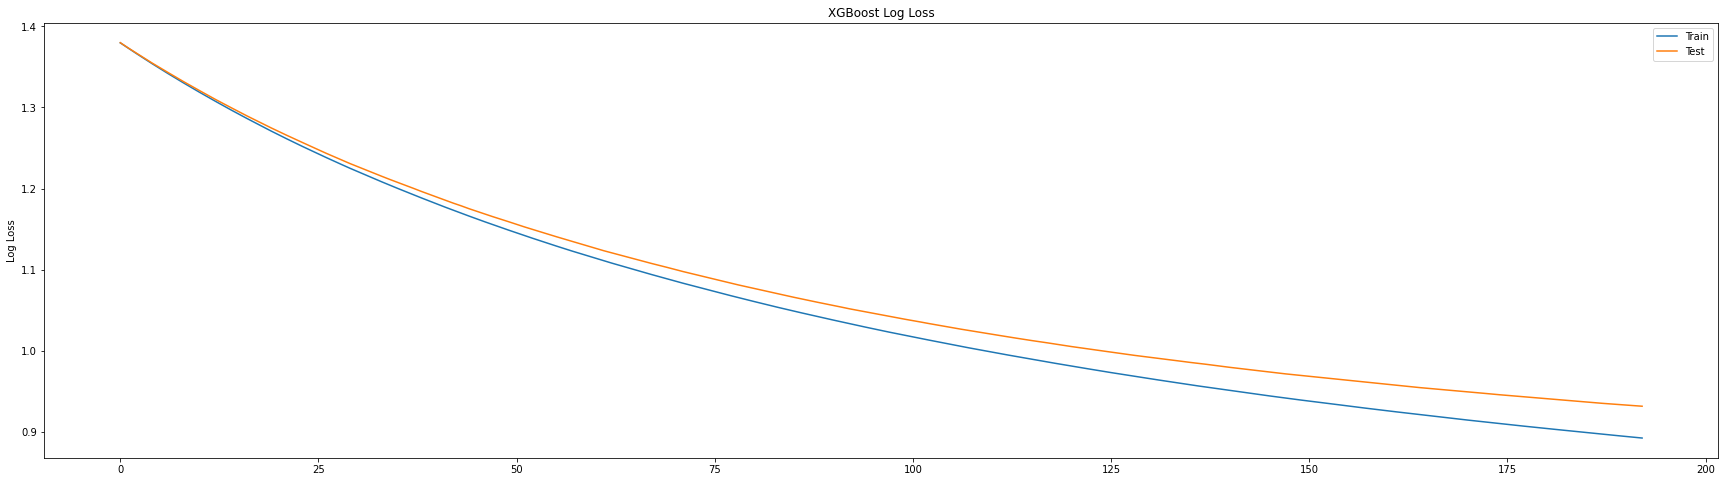

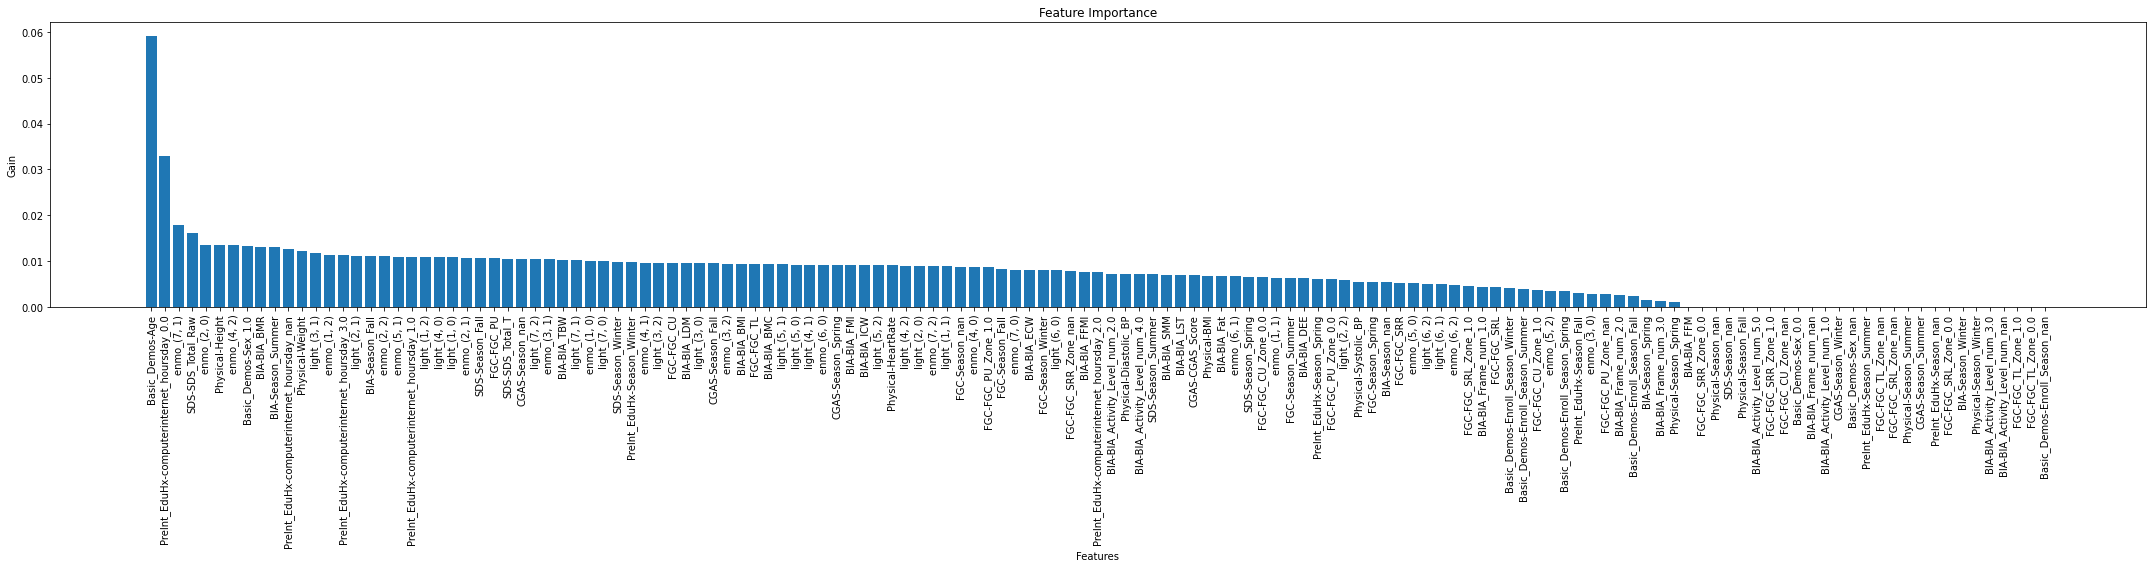

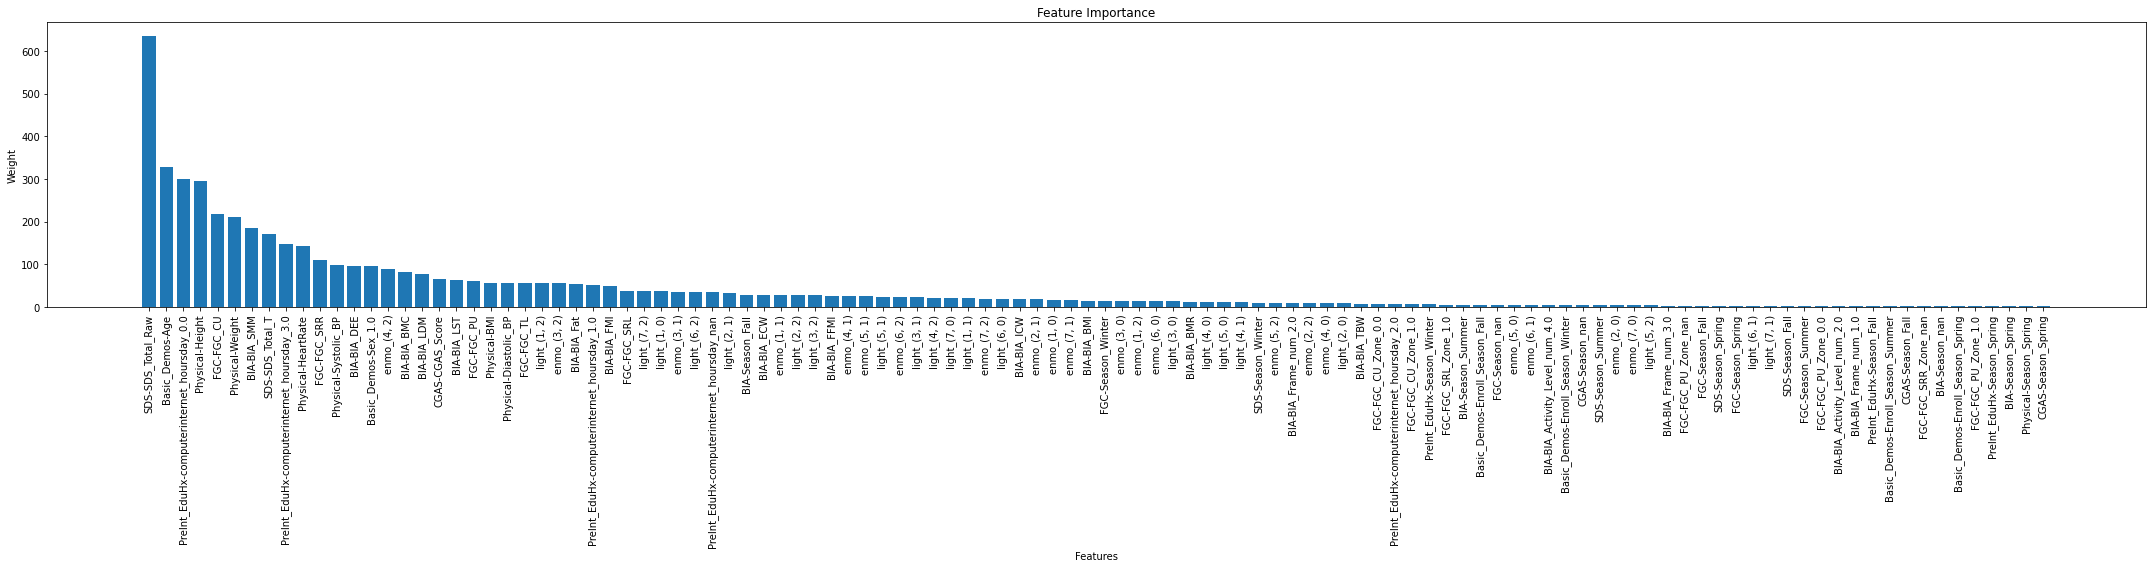

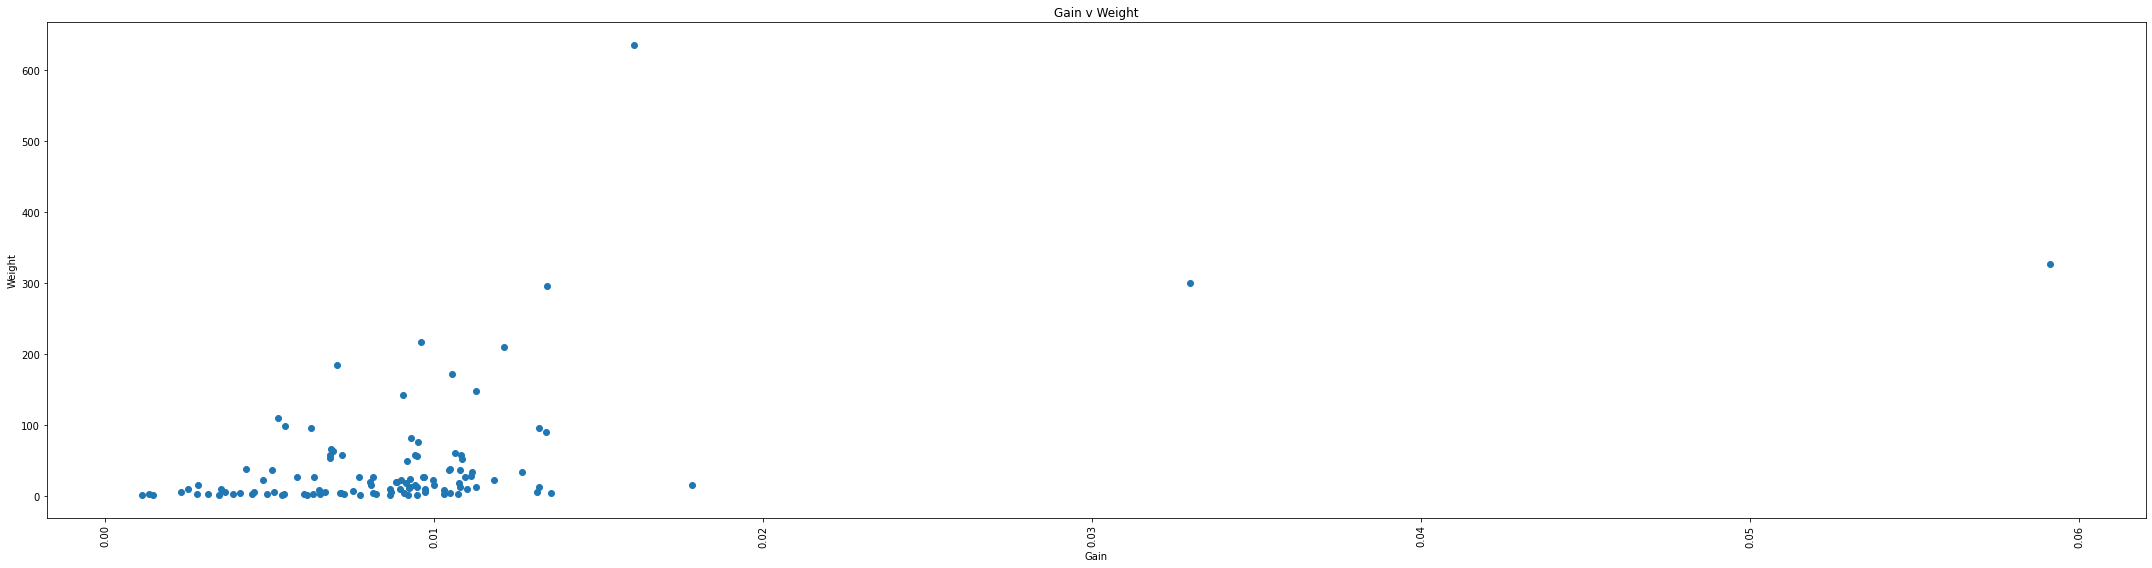

In [57]:
#xgb_model = XGBClassifier(objective = "multi:softprob", random_state = RANDOM_STATE, **best_params)#v1
xgb_model = XGBClassifier(objective = "multi:softprob", random_state = RANDOM_STATE, learning_rate = 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 193, subsample= 0.9)#v2
xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_val,y_val)], verbose=False)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
print(f"Number of epochs {epochs}")
plt.rcParams["figure.figsize"] = (30,8)

# plot log loss
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.savefig("Training_log_loss.svg")

# Plot normalized gain
gain = dict(zip(X_train.columns, xgb_model.feature_importances_))
gain = dict(sorted(gain.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots()
plt.bar(gain.keys(), gain.values())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Gain')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig("Xgboost_importance_normalized_gain.svg")

# Plot weight
weight = xgb_model.get_booster().get_score(importance_type= "weight")
weight = dict(sorted(weight.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots()
plt.bar(weight.keys(), weight.values())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig("Xgboost_importance_weight.svg")

gain_1 = []
weight_1 = []
for key, value in weight.items():
    gain_1.append(gain[key])
    weight_1.append(weight[key])

fig, ax = plt.subplots()
plt.scatter(gain_1, weight_1)
plt.xticks(rotation=90)
plt.xlabel('Gain')
plt.ylabel('Weight')
plt.title('Gain v Weight')
plt.tight_layout()
plt.savefig("Xgboost_importance_gain_v_weight.svg")
len(gain_1)

In [10]:
xgb_model.save_model("cmi_xgboost_model_v2_0.62.json")

NameError: name 'xgb_model' is not defined

# Process test data

In [26]:
#Read in test data
raw_test_df = pd.read_csv("dataset/test.csv")
print(raw_test_df.shape)

(20, 59)


In [27]:
# Transform test data
num_normalized_test_dataset = scaler.transform(raw_test_df[numeric_cols_standardize])
num_normalized_test_dataset = pd.DataFrame(num_normalized_test_dataset, columns = numeric_cols_standardize)
cat_dummies_test = pd.get_dummies(raw_test_df, columns = all_cat, dummy_na = True)

In [28]:
scaled_test_dataset = pd.concat([raw_test_df[['id']],num_normalized_test_dataset,cat_dummies_test[list(set(cat_dummies_test.columns).difference(raw_test_df.columns))]],axis=1)
scaled_test_dataset = scaled_test_dataset.fillna(scaled_full_dataset_num_medians)
scaled_test_dataset.set_index('id',inplace=True)

In [29]:
import preprocess_actigraph#need to do this due to issues with multiprocess in jupyter notebook on windows
actigraphy_data_parent_dir = "dataset/series_test.parquet"
all_patients_actigraphy_data_test = preprocess_actigraph.multi_preprocess_actigraphy_data(os.listdir(actigraphy_data_parent_dir), actigraphy_data_parent_dir, os.cpu_count())

In [30]:
#impute missing values
all_patients_actigraphy_data_imputed_test = all_patients_actigraphy_data_test.fillna(actigraphy_feature_medians)
all_patients_actigraphy_data_imputed_test.reset_index(inplace=True)
all_patients_actigraphy_data_imputed_test.drop(labels = ['index'],inplace=True,axis=1)

In [31]:
#Scale actigraphy data
__ids = all_patients_actigraphy_data_imputed_test.pop('id')
normalized_all_patients_actigraphy_data_test = scaler2.transform(all_patients_actigraphy_data_imputed_test)
normalized_all_patients_actigraphy_data_test = pd.DataFrame(normalized_all_patients_actigraphy_data_test, columns = all_patients_actigraphy_data_imputed_test.columns)
normalized_all_patients_actigraphy_data_test = pd.concat([__ids,normalized_all_patients_actigraphy_data_test],axis=1)
normalized_all_patients_actigraphy_data_test.set_index('id',inplace=True)

In [32]:
# Combine all transformed features
scaled_test_dataset_plus_acti = pd.concat([scaled_test_dataset,normalized_all_patients_actigraphy_data_test], axis=1)
acti_test_data_filled = scaled_test_dataset_plus_acti[acti_num_cols].fillna(0)
scaled_test_dataset_plus_acti.drop(labels=acti_num_cols,inplace=True, axis=1)
scaled_test_dataset_plus_acti = pd.concat([scaled_test_dataset_plus_acti,acti_test_data_filled], axis=1)

In [33]:
#Add in and fill missing features
missing_features = list(set(scaled_full_dataset_plus_acti).difference(scaled_test_dataset_plus_acti))

for feature in missing_features:
    scaled_test_dataset_plus_acti[feature] = 0

In [16]:
# Predict labels
xgb_model = XGBClassifier()
xgb_model.load_model("cmi_xgboost_model_v2_0.62")
y_pred = xgb_model.predict(scaled_full_dataset_plus_acti[scaled_full_dataset_plus_acti.columns])

In [17]:
# write results
predictions = pd.DataFrame.from_dict(dict(zip(scaled_full_dataset_plus_acti.index, y_pred)), orient='index')
predictions.reset_index(inplace=True)
predictions.to_csv("submission2.csv",header=["id",'sii'],index=False)